#Attention mechanism based Deep Neural Networks for robust breast cancer identification from mammography images

In [1]:
# imports
from collections import Counter
import cv2
import os
import glob
import skimage
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from io import BytesIO
from PIL import Image
from os import listdir
import matplotlib.pyplot as plt
from imageio import imread
from skimage.transform import resize
from collections import Counter
import IPython.display as display
import random

sns.set()


from sklearn.svm import SVC # SVC
from sklearn import metrics
from sklearn.utils import shuffle
from xgboost import XGBClassifier # XGBClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import compute_class_weight
from sklearn.preprocessing import MinMaxScaler,LabelBinarizer
from sklearn.ensemble import AdaBoostClassifier # AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier # KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier # RandomForestClassifier
from sklearn.model_selection import train_test_split



import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import AUC
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications.vgg16 import VGG16 # VGG16
from tensorflow.keras.applications.vgg19 import VGG19 # VGG19
from tensorflow.keras.applications.resnet50 import ResNet50 # ResNet50
from tensorflow.keras.applications.xception import Xception # Xception
from tensorflow.keras.applications.mobilenet import MobileNet # MobileNet
from tensorflow.keras.applications.nasnet import NASNetMobile # NASNetMobile
from tensorflow.keras.applications.densenet import DenseNet169 # DenseNet169
from tensorflow.keras.applications.densenet import DenseNet121 # DenseNet121
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2 # MobileNetV2
from tensorflow.keras.applications.inception_v3 import InceptionV3 # InceptionV3
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Flatten, Activation, GlobalAveragePooling2D,Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [2]:
# # Content Folder is Ephemeral (so have to get dataset once per session)

# from google.colab import drive
# drive.mount('/content/drive')
# ! mkdir -p /content/.kaggle
# !cp /content/drive/MyDrive/KaggleAPI/kaggle.json /content/.kaggle
# ! chmod 600 /content/.kaggle/kaggle.json
# !kaggle datasets download -d skooch/ddsm-mammography -p /content
# !unzip /content/ddsm-mammography.zip -d /content/DataSet




#Understanding the data



In [3]:
images=[]
labels=[]
feature_dictionary = {
    'label': tf.io.FixedLenFeature([], tf.int64),
    'label_normal': tf.io.FixedLenFeature([], tf.int64),
    'image': tf.io.FixedLenFeature([], tf.string)
    }

# labeL normal : normal / abnormal
# LABEL : multi class classfication

In [4]:
def _parse_function(example, feature_dictionary=feature_dictionary):
    parsed_example = tf.io.parse_example(example, feature_dictionary)
    return parsed_example

def read_data(filename):
    full_dataset = tf.data.TFRecordDataset(filename,num_parallel_reads=tf.data.experimental.AUTOTUNE)
    full_dataset = full_dataset.shuffle(buffer_size=31000)
    full_dataset = full_dataset.cache()
    print("Size of Training Dataset: ", len(list(full_dataset)))


    feature_dictionary = {
    'label': tf.io.FixedLenFeature([], tf.int64),
    'label_normal': tf.io.FixedLenFeature([], tf.int64),
    'image': tf.io.FixedLenFeature([], tf.string)
    }

    full_dataset = full_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    print(full_dataset)
    for image_features in full_dataset:
        image = image_features['image'].numpy()
        image = tf.io.decode_raw(image_features['image'], tf.uint8)
        image = tf.reshape(image, [299, 299])
        image=image.numpy()
        image=cv2.resize(image,(100,100))
        image=cv2.merge([image,image,image])
        #plt.imshow(image)
        images.append(image)
        labels.append(image_features['label_normal'].numpy())

In [5]:
filenames=['/content/DataSet/training10_0/training10_0.tfrecords'
          # '/content/DataSet/training10_1/training10_1.tfrecords',
          # '/content/DataSet/training10_2/training10_2.tfrecords',
          # '/content/DataSet/training10_3/training10_3.tfrecords',
          # '/content/DataSet/training10_4/training10_4.tfrecords'
          ]

for file in filenames:
    read_data(file)

print(len(images))
print(len(labels))

Size of Training Dataset:  11177
<_ParallelMapDataset element_spec={'image': TensorSpec(shape=(), dtype=tf.string, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'label_normal': TensorSpec(shape=(), dtype=tf.int64, name=None)}>
11177
11177


In [6]:
#1. Image Data Overview and Shape Statistics
print(f"Total images: {len(images)}")
print(f"Image shape: {np.array(images[0]).shape}")  # Check the shape of one image

# Check for unique image shapes (for consistency check)
shapes = [img.shape for img in images]
unique_shapes = set(shapes)
print(f"Unique image shapes: {unique_shapes}")


Total images: 11177
Image shape: (100, 100, 3)
Unique image shapes: {(100, 100, 3)}


In [7]:
#  Check Image Pixel Value Range:
# Check the pixel value range in one sample image
print("Min pixel value:", np.min(images[0]))
print("Max pixel value:", np.max(images[0]))


Min pixel value: 84
Max pixel value: 133


In [8]:
# Check the datatype of the images
print("Data type of the image:", images[0].dtype)


Data type of the image: uint8


In [9]:
# Count the distribution of binary labels (normal/abnormal)
label_normal_distribution = Counter(labels)
print("Binary class distribution (label_normal):", label_normal_distribution)

Binary class distribution (label_normal): Counter({0: 9698, 1: 1479})


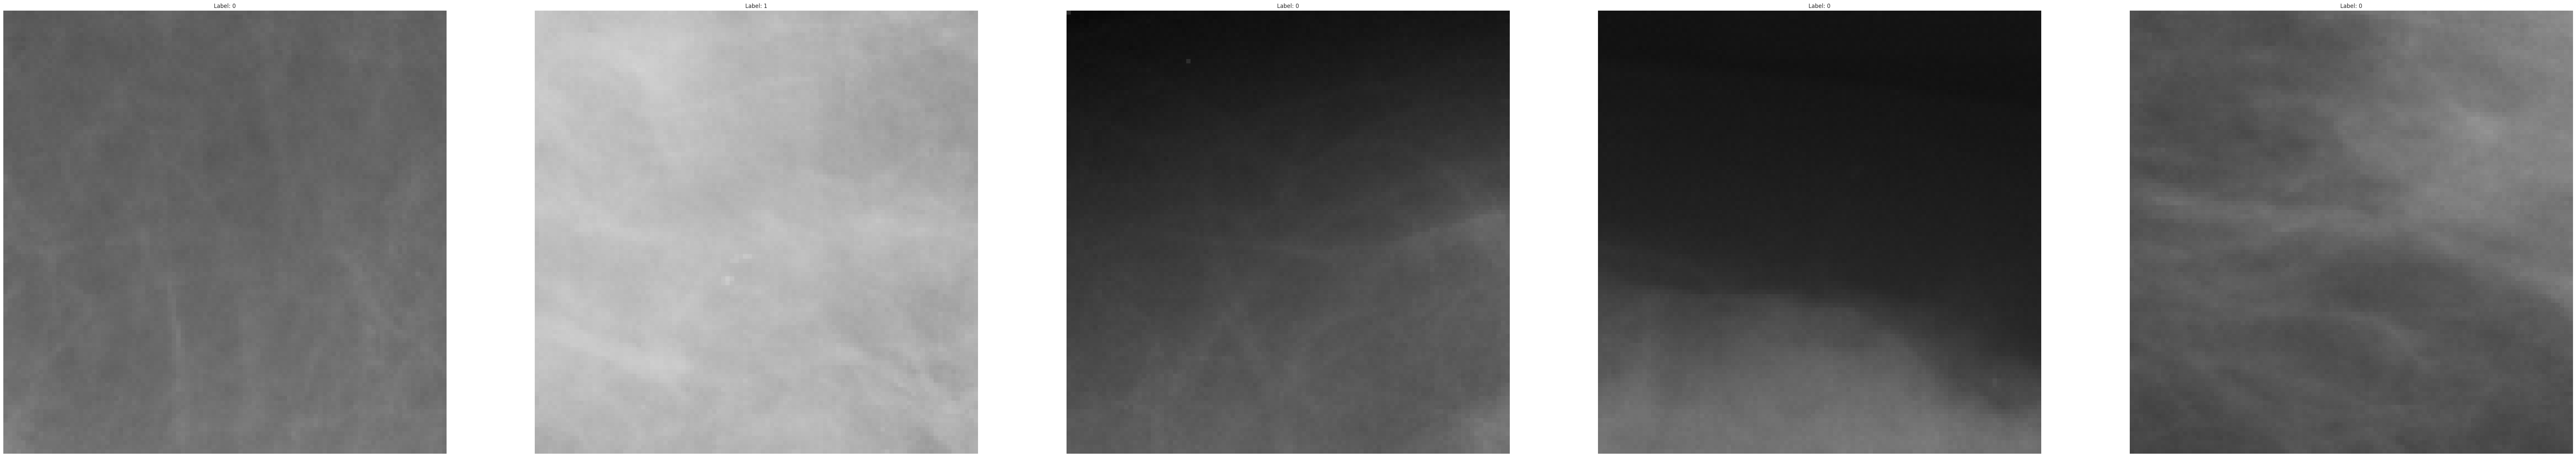

In [10]:
import matplotlib.pyplot as plt

# Plot some sample images from both classes
def plot_sample_images(images, labels, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(100, 100))
    for i in range(num_samples):
        axes[i].imshow(images[i])
        axes[i].set_title(f"Label: {labels[i]}")
        axes[i].axis('off')
    plt.show()

# Plot 5 random images
plot_sample_images(images, labels)


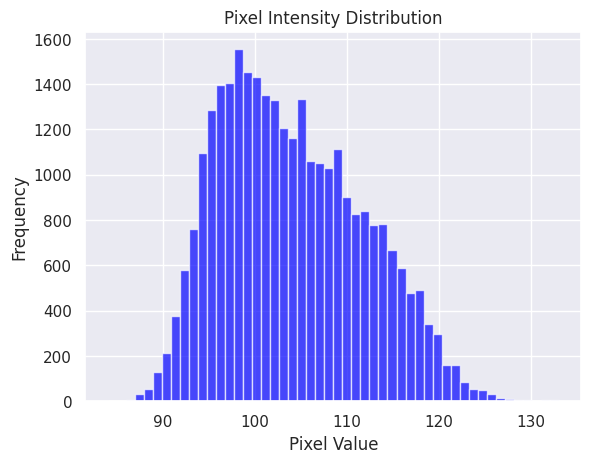

In [11]:
# Flatten an image to check the pixel distribution
flattened_image = images[0].flatten()

# Plot the distribution of pixel values
plt.hist(flattened_image, bins=50, color='blue', alpha=0.7)
plt.title('Pixel Intensity Distribution')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.show()


In [12]:
# # Calculate the mean and standard deviation across all images
# mean_image = np.mean(images, axis=0)
# std_image = np.std(images, axis=0)

# # Plot mean image
# plt.imshow(mean_image.astype(np.uint8))
# plt.title('Mean Image')
# plt.axis('off')
# plt.show()

# # Plot standard deviation image
# plt.imshow(std_image.astype(np.uint8), cmap='gray')
# plt.title('Standard Deviation Image')
# plt.axis('off')
# plt.show()


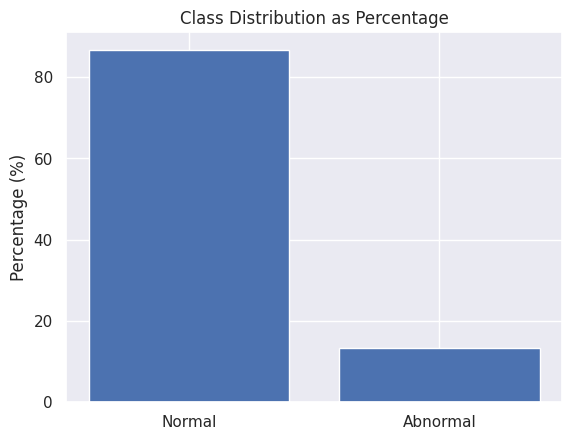

In [13]:
import matplotlib.pyplot as plt

# Compute percentages
class_counts = np.bincount(labels)
class_percentages = class_counts / len(labels) * 100

# Plot the percentages
plt.bar(['Normal', 'Abnormal'], class_percentages)
plt.title('Class Distribution as Percentage')
plt.ylabel('Percentage (%)')
plt.show()


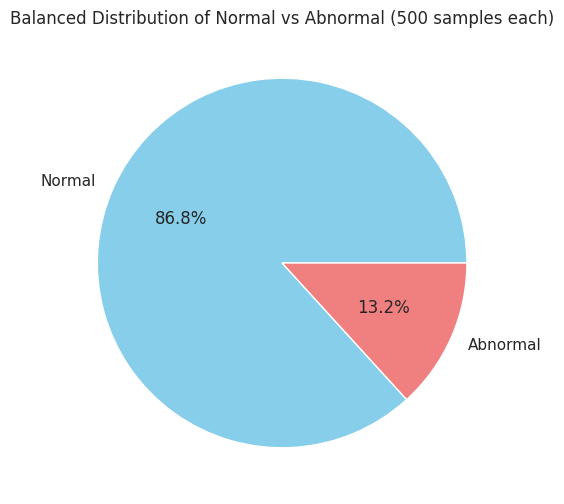

In [14]:
import matplotlib.pyplot as plt

# Count the occurrences of each class
class_counts = np.bincount(labels)

# Create a pie chart
plt.figure(figsize=(6, 6))
plt.pie(class_counts, labels=['Normal', 'Abnormal'], autopct='%1.1f%%', colors=['skyblue', 'lightcoral'])
plt.title('Balanced Distribution of Normal vs Abnormal (500 samples each)')
plt.show()


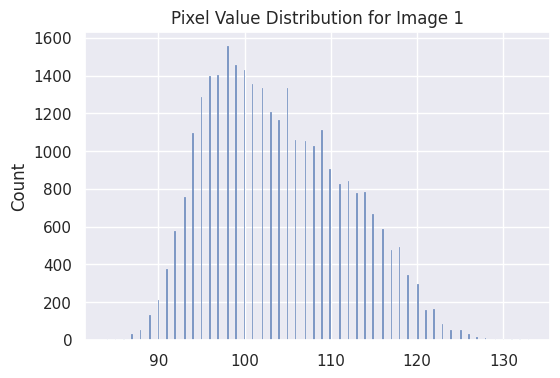

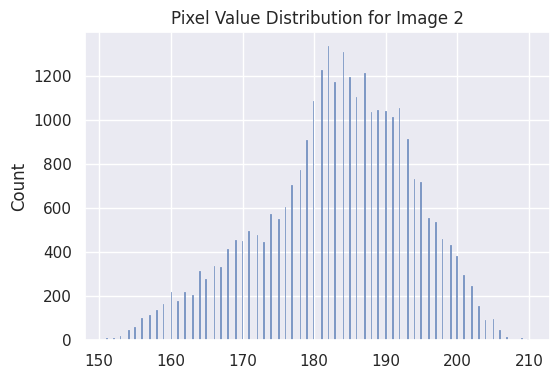

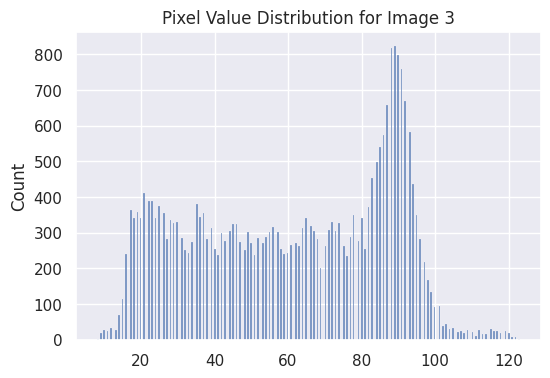

In [15]:
#3. Pixel Value Distribution
#The pixel intensity range for medical images is essential for understanding contrast and brightness.
#Visualizing pixel value distributions across a few sample images can help identify any irregularities.


for i in range(3):  # Check for 3 random images
    plt.figure(figsize=(6, 4))
    sns.histplot(images[i].ravel(), bins=256, kde=False)
    plt.title(f'Pixel Value Distribution for Image {i+1}')
    plt.show()


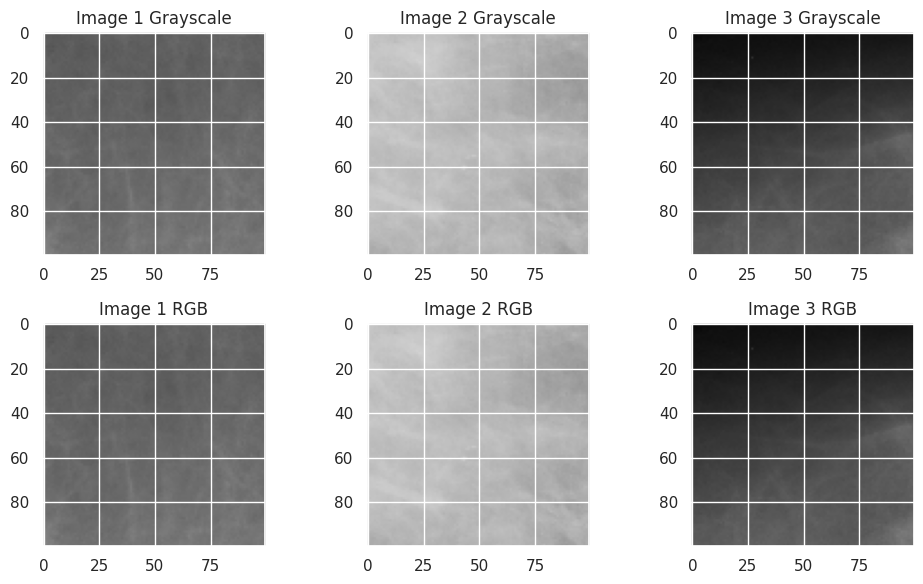

In [16]:
#4. Image Visualization (RGB and Grayscale)

#A quick look at a few images in both grayscale and RGB format will help understand their visual quality and consistency.


fig, ax = plt.subplots(2, 3, figsize=(10, 6))
for i in range(3):
    ax[0, i].imshow(images[i], cmap='gray')  # Grayscale visualization
    ax[0, i].set_title(f'Image {i+1} Grayscale')
    ax[1, i].imshow(images[i])  # RGB visualization
    ax[1, i].set_title(f'Image {i+1} RGB')
plt.tight_layout()
plt.show()


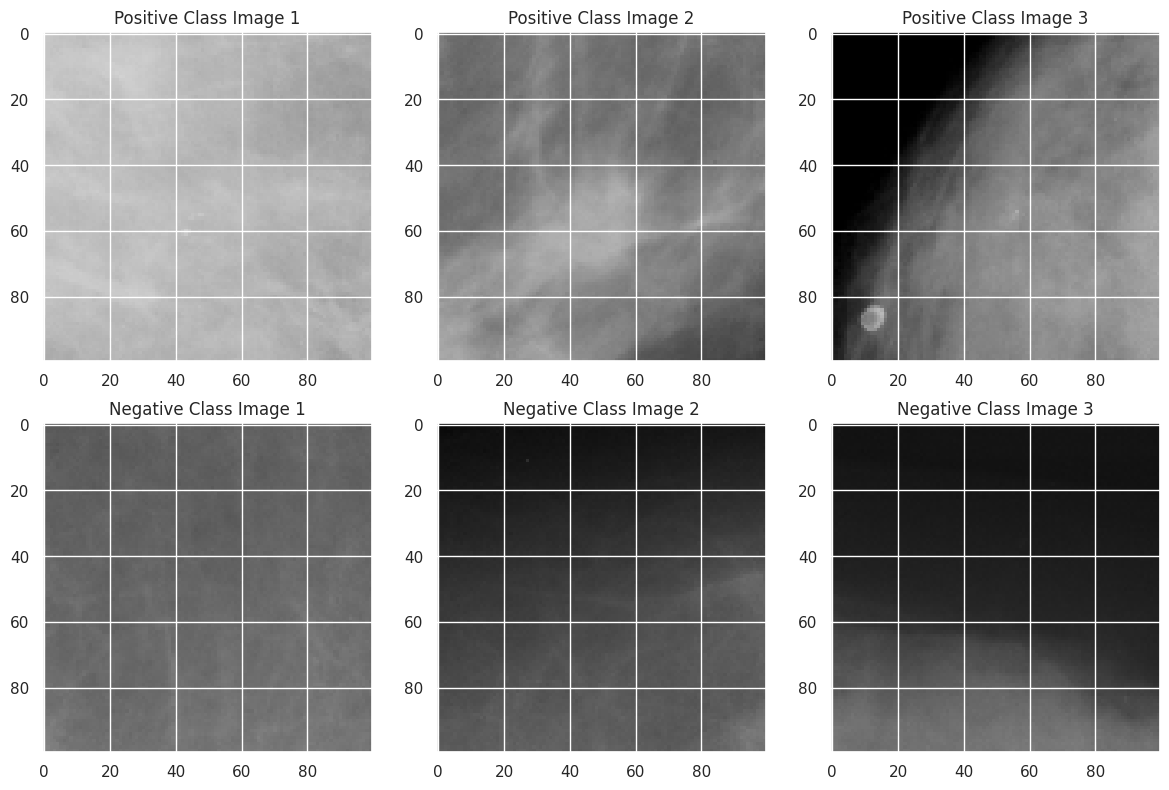

In [17]:
#7. Class-wise Image Distribution
# Visualize a few positive and negative examples
pos_images = [img for img, label in zip(images, labels) if label == 1][:3]
neg_images = [img for img, label in zip(images, labels) if label == 0][:3]

fig, ax = plt.subplots(2, 3, figsize=(12, 8))
for i in range(3):
    ax[0, i].imshow(pos_images[i])
    ax[0, i].set_title(f'Positive Class Image {i+1}')
    ax[1, i].imshow(neg_images[i])
    ax[1, i].set_title(f'Negative Class Image {i+1}')
plt.tight_layout()
plt.show()


In [18]:
#8. Statistical Summary of Pixel Values
pixel_means = [np.mean(img) for img in images]
pixel_stds = [np.std(img) for img in images]

print(f"Average pixel mean: {np.mean(pixel_means)}")
print(f"Average pixel std deviation: {np.mean(pixel_stds)}")


Average pixel mean: 91.04019766484745
Average pixel std deviation: 20.820439929643552


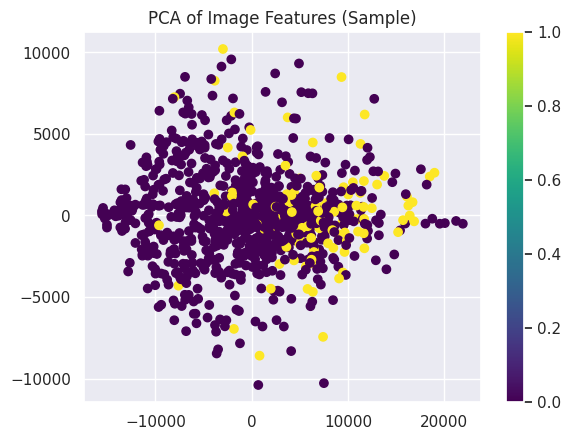

In [19]:
from sklearn.decomposition import PCA

# Subset of 1000 images for PCA (assuming images is a list of numpy arrays)
sample_images = np.array([img.flatten() for img in images[:1000]])

# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(sample_images)

# Visualize the PCA results
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=labels[:1000], cmap='viridis')
plt.title('PCA of Image Features (Sample)')
plt.colorbar()
plt.show()


###Dealing with Imbalanced Data


In [20]:
#1) classweights in training process
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weight_dict = dict(enumerate(class_weights))

# model.fit(X_train, y_train, class_weight=class_weight_dict)


#Monitoring Metrics
# Make sure you track precision, recall, and F1-scores during training, as they are more meaningful metrics than accuracy for imbalanced data.
# Use AUC-ROC to monitor performance with imbalanced classes.

##DATA AUGMENTATION

#Key Augmentations Included:

Rescaling to normalize pixel values.

Rotation, width, and height shifts, zoom, and brightness adjustments.

Noise augmentation up to 20%.

Grayscale transformation and resizing to 124x124.



In [21]:
# xd

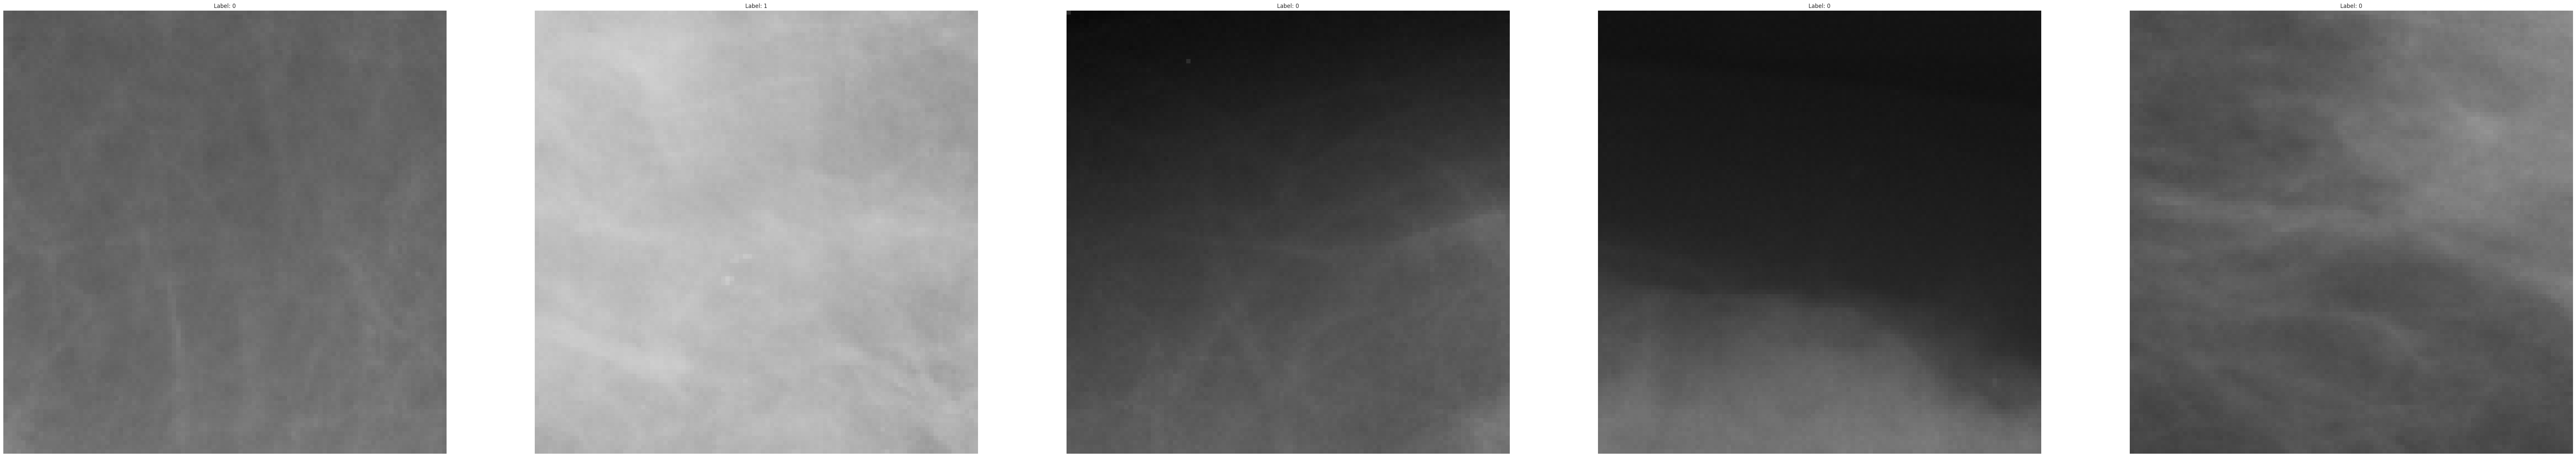

In [22]:
# Visualize a few  images

def plot_sample_images(images, labels, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(100, 100))
    for i in range(num_samples):
        axes[i].imshow(images[i])
        axes[i].set_title(f"Label: {labels[i]}")
        axes[i].axis('off')
    plt.show()
plot_sample_images(images, labels)


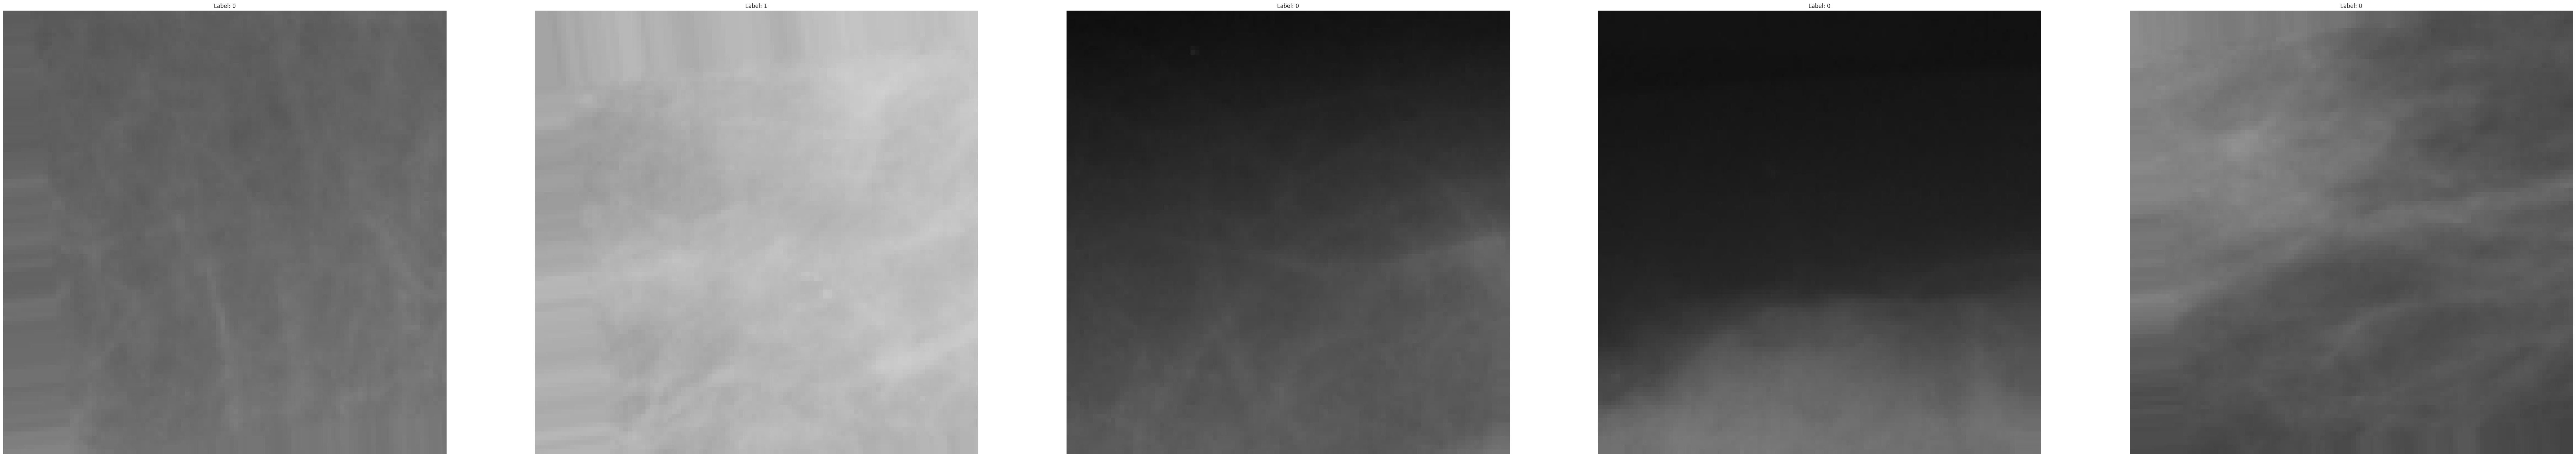

In [23]:
# Assuming 'images' is your list of images
# Convert the list of images to a NumPy array
images_array = np.array(images)

# Normalize images to the range [0, 1]
images_normalized = images_array.astype(np.float32) / 255.0

# Define a function to add Gaussian noise
def add_gaussian_noise(image):
    noise = np.random.normal(0, 0.05, image.shape)  # Adjust noise parameters as needed
    noisy_image = image + noise
    return np.clip(noisy_image, 0., 1.)  # Ensure pixel values remain in [0, 1]

# Create ImageDataGenerator with the noise function
datagen = ImageDataGenerator(
    rotation_range=10,             # Rotate images up to 10 degrees
    width_shift_range=0.1,         # Shift the width by 10%
    height_shift_range=0.1,        # Shift the height by 10%
    zoom_range=0.1,                # Zoom by up to 10%
    # brightness_range=[0.9, 1.1],   # Adjust brightness ( DOSENT WORK)
    horizontal_flip=True,          # Random horizontal flipping
    # preprocessing_function=add_gaussian_noise  # Add Gaussian noise
)

# Apply augmentation using the ImageDataGenerator
augmented_images = []
for image in images_normalized:
    image = image.reshape((1,) + image.shape)  # Reshape to fit the generator
    # Generate augmented images
    for batch in datagen.flow(image, batch_size=1):
        augmented_images.append(batch[0])
        break  # Only need one augmented version per image

# Convert the list to a numpy array for easier manipulation
augmented_images = np.array(augmented_images)

# Convert back to the correct format for training
augmented_images = np.clip(augmented_images * 255, 0, 255).astype(np.uint8)

# Function to plot sample images
def plot_sample_images(images, labels, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(100, 100))  # Adjusted figsize for better visualization
    for i in range(num_samples):
        axes[i].imshow(images[i])
        axes[i].set_title(f"Label: {labels[i]}")
        axes[i].axis('off')
    plt.show()

# Plot the augmented images
plot_sample_images(augmented_images, labels)

In [24]:
## SORT


# # Define the Keras ImageDataGenerator for data augmentation

# def add_gaussian_noise(image):
#     noise = np.random.normal(0, 0.05, image.shape)  # Adjust noise parameters as needed
#     noisy_image = image + noise
#     return np.clip(noisy_image, 0., 1.)  # Ensure pixel values remain in [0, 1]



# datagen = ImageDataGenerator(
#     rotation_range=10,             # Rotate images up to 10 degrees
#     width_shift_range=0.1,         # Shift the width by 10%
#     height_shift_range=0.1,        # Shift the height by 10%
#     zoom_range=0.1,                # Zoom by up to 10%
#     brightness_range=[0.1, 1.1],   # Adjust brightness
#     horizontal_flip=True,          # Random horizontal flipping
#     # preprocessing_function=add_gaussian_noise  # Add Gaussian noise
# )

# # # Function to add Gaussian noise
# # def add_gaussian_noise(images, noise_factor=0.05):  # Reduced noise_factor
# #     noise = noise_factor * np.random.randn(*images.shape)
# #     augmented_images = images + noise
# #     augmented_images = np.clip(augmented_images, 0., 1.)
# #     return augmented_images


# # Apply augmentation using the ImageDataGenerator
# augmented_images = []
# for image in images:
#     image = image.reshape((1,) + image.shape)  # Reshape to fit the generator
#     # Generate augmented images
#     for batch in datagen.flow(image, batch_size=1):
#         augmented_images.append(batch[0])
#         break  # Only need one augmented version per image


# # Convert the list to a numpy array for easier manipulation
# augmented_images = np.array(augmented_images)
# # Convert back to the correct format for training
# augmented_images= np.clip(augmented_images * 255, 0, 255).astype(np.uint8)


# # # Visualize a few augmented images
# # import matplotlib.pyplot as plt
# # for i in range(5):
# #     plt.imshow(augmented_images[i].reshape(100, 100), cmap='gray')
# #     plt.show()


# def plot_sample_images(images, labels, num_samples=5):
#     fig, axes = plt.subplots(1, num_samples, figsize=(100, 100))
#     for i in range(num_samples):
#         axes[i].imshow(images[i])
#         axes[i].set_title(f"Label: {labels[i]}")
#         axes[i].axis('off')
#     plt.show()
# plot_sample_images(augmented_images, labels)


#MODEL TRAINING

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Conv2D, MaxPooling2D, Flatten, BatchNormalization
from tensorflow.keras.applications import VGG16, VGG19, ResNet50, EfficientNetB0, EfficientNetB1
from tensorflow.keras.optimizers import Adam, Nadam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt


In [ ]:

# Data preparation
X = np.array(augmented_images)
y = np.array(labels)

In [ ]:
# Split the dataset for training and testing
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2021, shuffle=True)

In [ ]:


# Define function to create model architecture
def create_model(base_model_name, dropout_rate=0.2, optimizer='adam'):
    if base_model_name == 'VGG16':
        base_model = VGG16(weights='imagenet', include_top=False, input_shape=(100, 100, 3))
    elif base_model_name == 'VGG19':
        base_model = VGG19(weights='imagenet', include_top=False, input_shape=(100, 100, 3))
    elif base_model_name == 'ResNet50':
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(100, 100, 3))
    elif base_model_name == 'EfficientNetB0':
        base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(100, 100, 3))
    elif base_model_name == 'EfficientNetB1':
        base_model = EfficientNetB1(weights='imagenet', include_top=False, input_shape=(100, 100, 3))

    # Freeze the base model layers
    base_model.trainable = False

    model = Sequential([
        base_model,
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')  # Binary classification
    ])

    # Compile model with selected optimizer
    if optimizer == 'adam':
        opt = Adam()
    elif optimizer == 'nadam':
        opt = Nadam()
    elif optimizer == 'rmsprop':
        opt = RMSprop()

    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Training and evaluating models with different optimizers
optimizers = ['adam', 'nadam', 'rmsprop']
models = ['VGG16', 'VGG19', 'ResNet50', 'EfficientNetB0', 'EfficientNetB1']
history_dict = {}


In [ ]:

for model_name in models:
    for optimizer in optimizers:
        print(f"Training {model_name} with {optimizer} optimizer.")
        model = create_model(model_name, optimizer=optimizer)

        # Use early stopping to prevent overfitting
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        # Train the model
        history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=5, batch_size=32, callbacks=[early_stopping])

        # Save history for plotting
        history_dict[f'{model_name}_{optimizer}'] = history


In [ ]:

# Plot Training and Validation Loss/Accuracy
def plot_metrics(history, model_name, optimizer):
    # Accuracy plot
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} - {optimizer}: Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} - {optimizer}: Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

Training VGG16 with adam optimizer.
Epoch 1/5
280/280 ━━━━━━━━━━━━━━━━━━━━ 30s 81ms/step - accuracy: 0.8382 - loss: 0.7521 - val_accuracy: 0.8810 - val_loss: 0.3144
Epoch 2/5
280/280 ━━━━━━━━━━━━━━━━━━━━ 24s 40ms/step - accuracy: 0.9028 - loss: 0.2512 - val_accuracy: 0.8842 - val_loss: 0.2968
Epoch 3/5
280/280 ━━━━━━━━━━━━━━━━━━━━ 21s 40ms/step - accuracy: 0.9120 - loss: 0.2087 - val_accuracy: 0.8788 - val_loss: 0.2907
Epoch 4/5
280/280 ━━━━━━━━━━━━━━━━━━━━ 21s 41ms/step - accuracy: 0.9360 - loss: 0.1711 - val_accuracy: 0.8900 - val_loss: 0.2950
Epoch 5/5
280/280 ━━━━━━━━━━━━━━━━━━━━ 21s 42ms/step - accuracy: 0.9355 - loss: 0.1617 - val_accuracy: 0.8945 - val_loss: 0.3283
Training VGG16 with nadam optimizer.
Epoch 1/5
280/280 ━━━━━━━━━━━━━━━━━━━━ 18s 51ms/step - accuracy: 0.8378 - loss: 0.7486 - val_accuracy: 0.8775 - val_loss: 0.3070
Epoch 2/5
280/280 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9014 - loss: 0.2455 - val_accuracy: 0.8860 - val_loss: 0.2975
Epoch 3/5
280/280 ━━━━━━

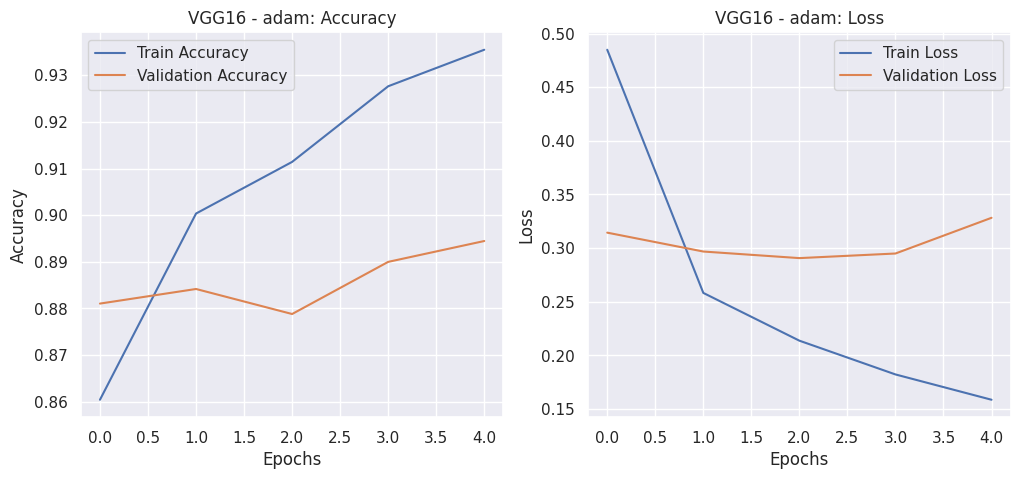

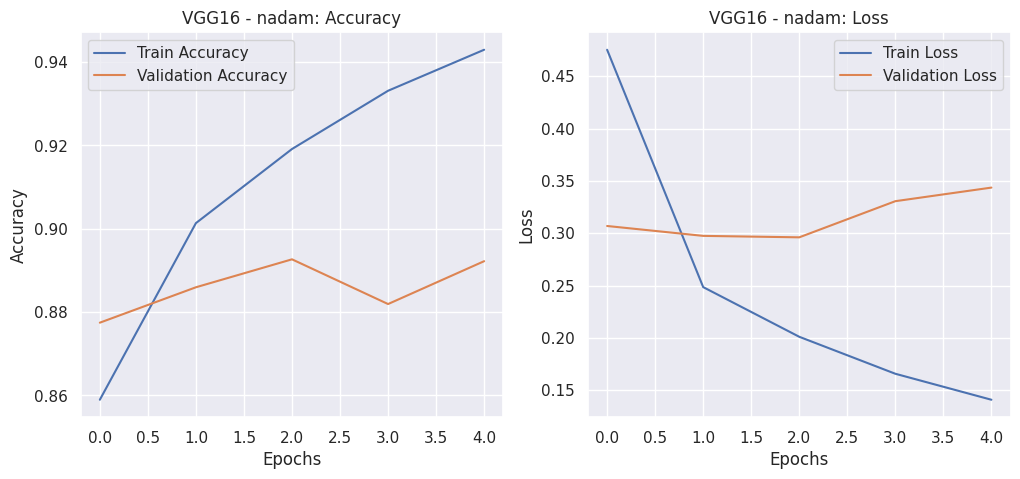

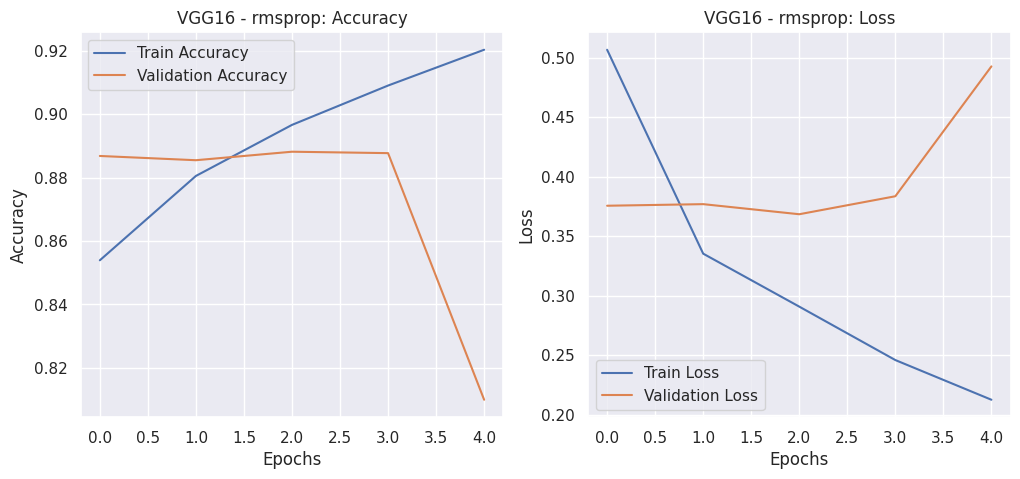

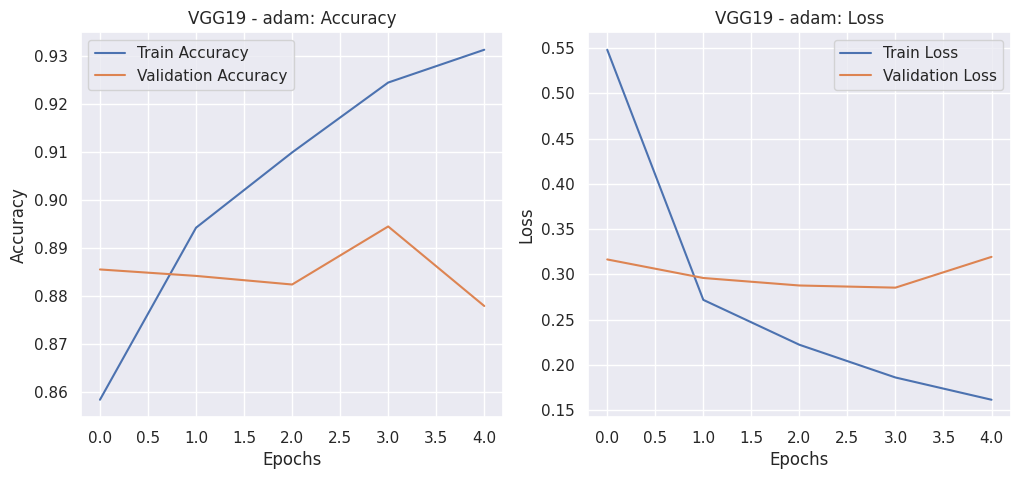

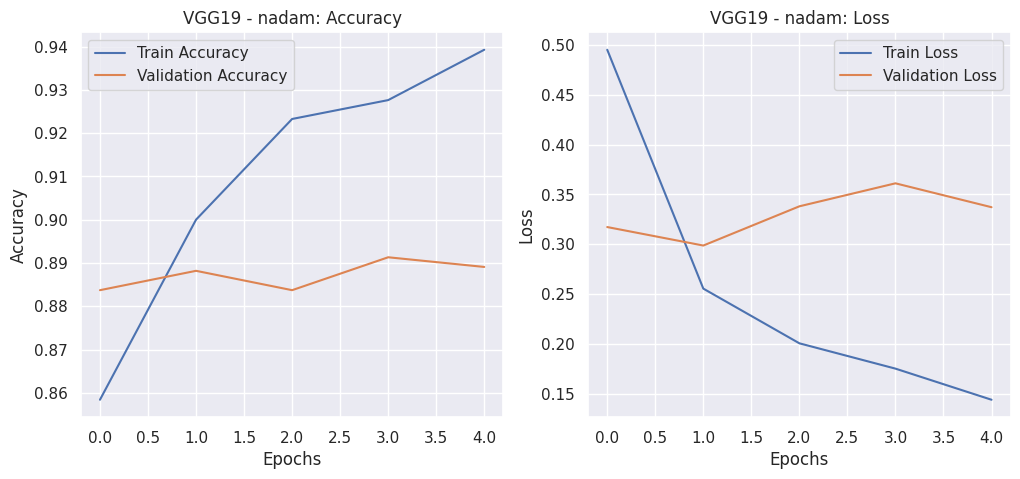

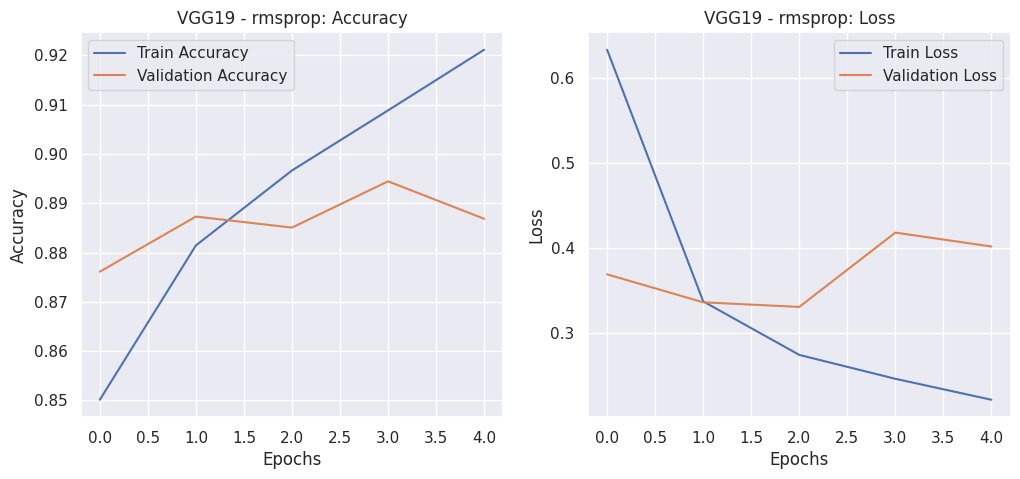

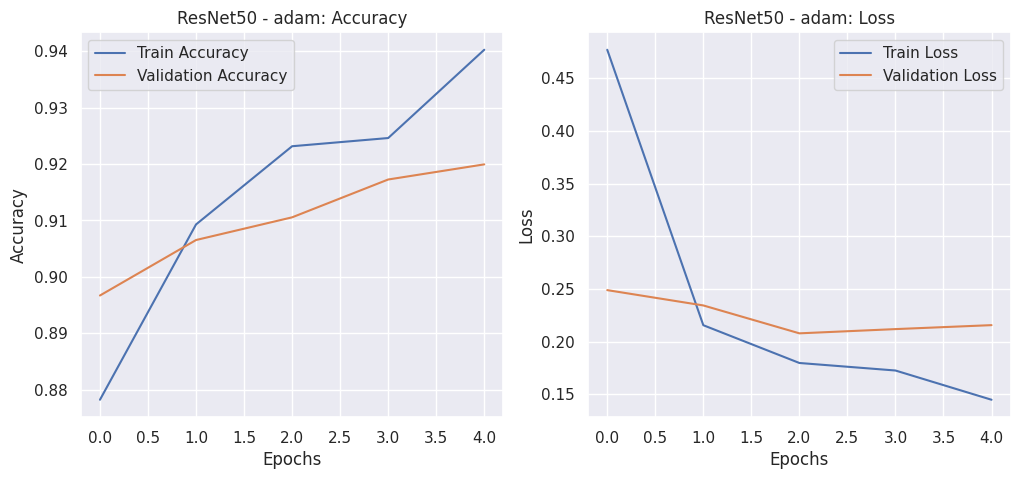

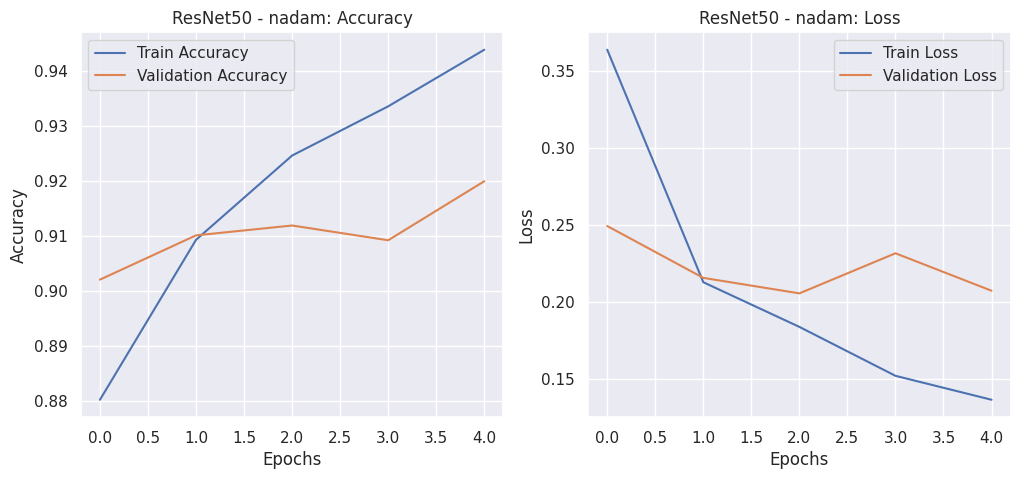

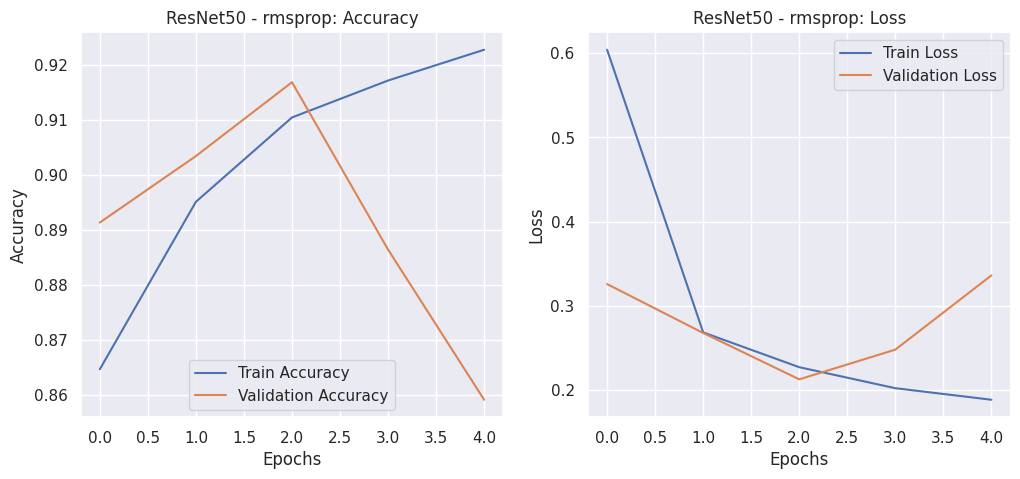

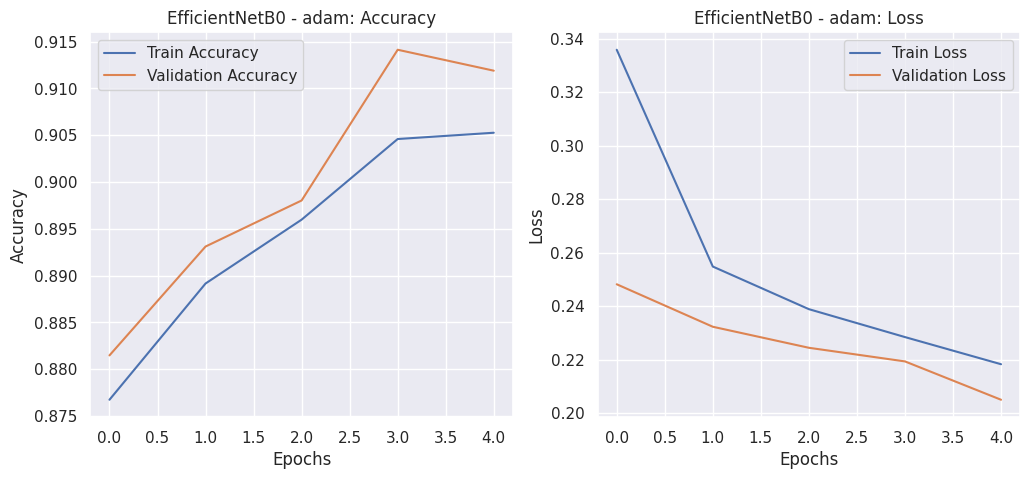

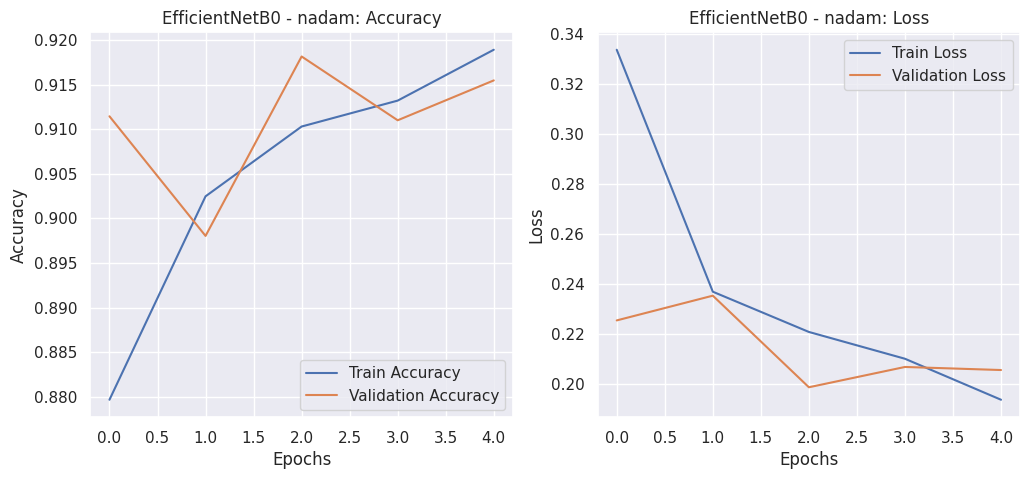

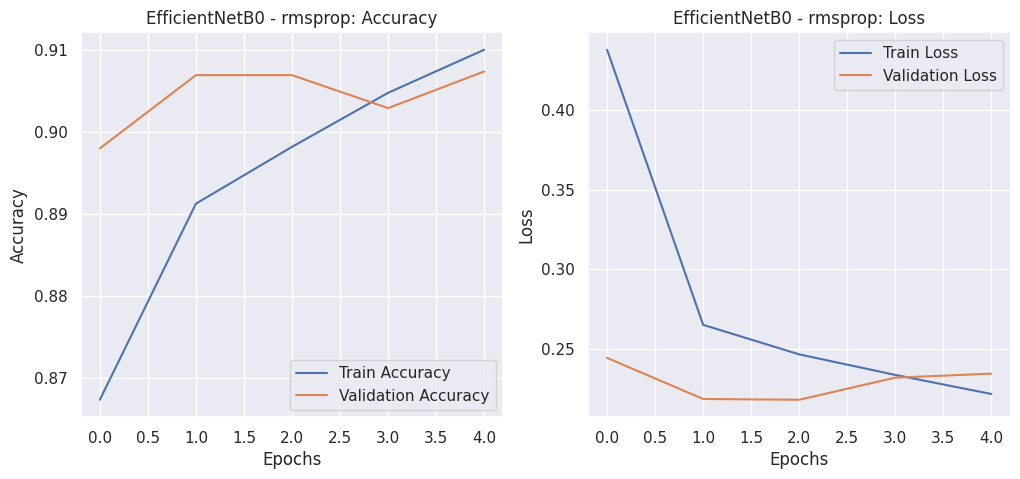

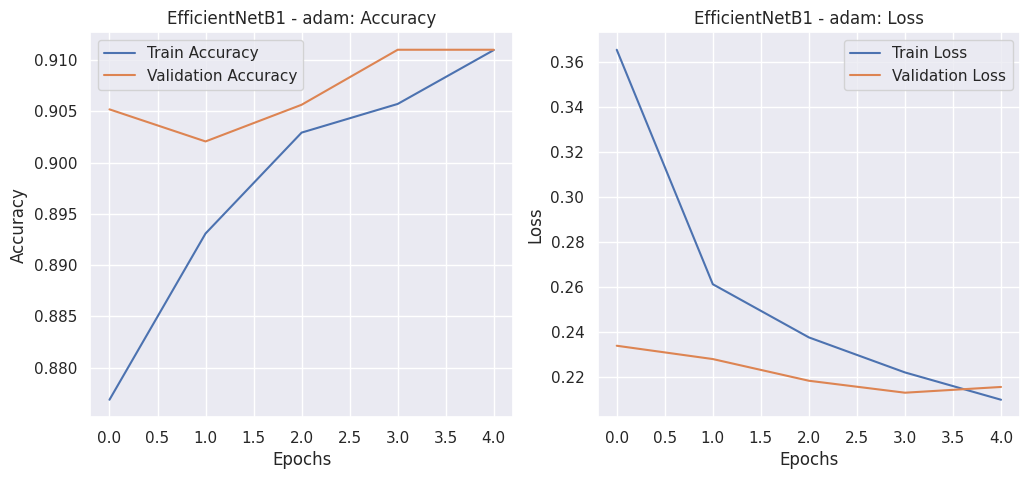

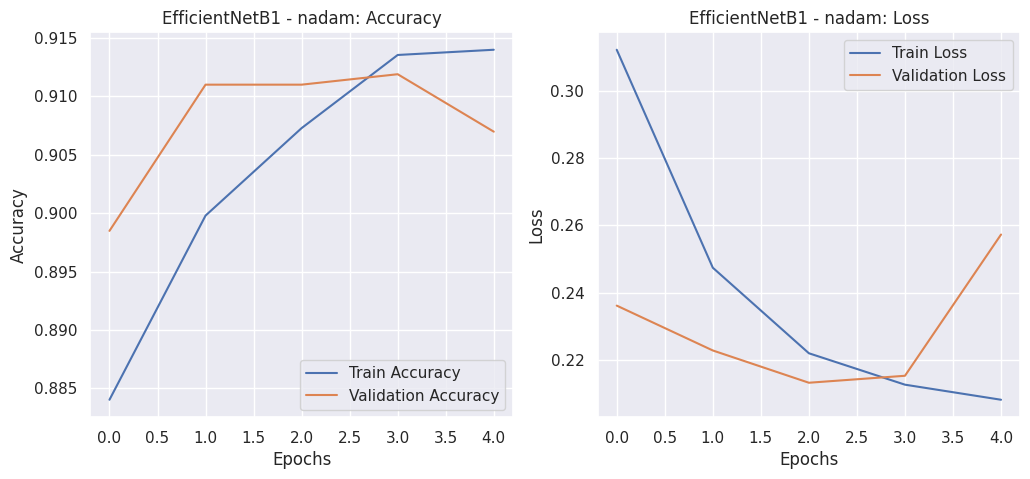

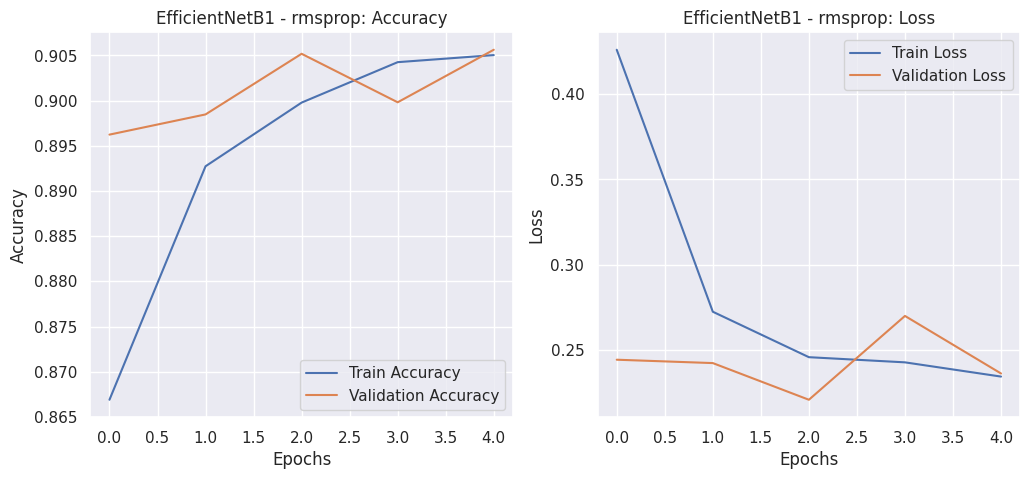

Epoch 1/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 31s 64ms/step - accuracy: 0.8478 - loss: 1.0789 - val_accuracy: 0.9056 - val_loss: 0.2321
Epoch 2/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 34s 56ms/step - accuracy: 0.9004 - loss: 0.2309 - val_accuracy: 0.9079 - val_loss: 0.2181
Epoch 3/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.9133 - loss: 0.1943 - val_accuracy: 0.9159 - val_loss: 0.2236
Epoch 4/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.9192 - loss: 0.1719 - val_accuracy: 0.9146 - val_loss: 0.2048
Epoch 5/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - accuracy: 0.9377 - loss: 0.1446 - val_accuracy: 0.9191 - val_loss: 0.2095
Epoch 6/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - accuracy: 0.9502 - loss: 0.1221 - val_accuracy: 0.9226 - val_loss: 0.1936
Epoch 7/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 19s 33ms/step - accuracy: 0.9403 - loss: 0.1374 - val_accuracy: 0.9173 - val_loss: 0.2032
Epoch 8/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.9577 - loss: 0.0975 - 

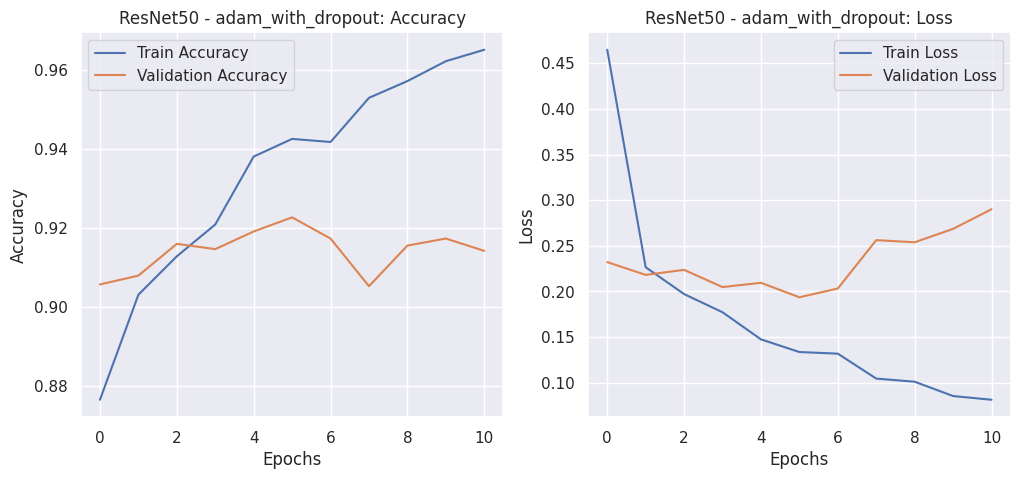

In [25]:
# Plot results for all models and optimizers
for key, history in history_dict.items():
    model_name, optimizer = key.split('_')
    plot_metrics(history, model_name, optimizer)

# Overfitting detection: If the validation accuracy is significantly lower than training accuracy, model is overfitting
# Underfitting detection: If both training and validation accuracy are low, model is underfitting

# Example of using dropout to mitigate overfitting
def create_model_with_dropout(base_model_name, dropout_rate=0.2, optimizer='adam'):
    model = create_model(base_model_name, dropout_rate=dropout_rate, optimizer=optimizer)
    return model

# Test dropout layer (for example) in ResNet50 with Adam optimizer
model_with_dropout = create_model_with_dropout('ResNet50', dropout_rate=0.2, optimizer='adam')
history_with_dropout = model_with_dropout.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=30, batch_size=32, callbacks=[early_stopping])

# Plot training with dropout
plot_metrics(history_with_dropout, 'ResNet50', 'adam_with_dropout')

# Conclusion: Evaluate model performance based on validation accuracy and detect overfitting/underfitting


70/70 ━━━━━━━━━━━━━━━━━━━━ 10s 86ms/step


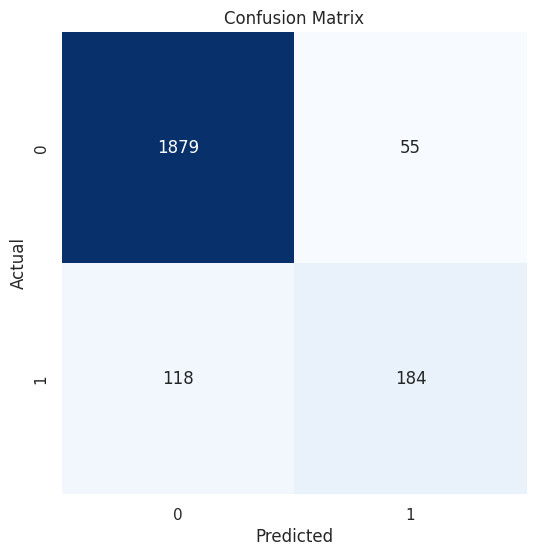

Precision: 0.7699
Recall: 0.6093
F1 Score: 0.6802

Classification Report:

              precision    recall  f1-score   support

           0       0.94      0.97      0.96      1934
           1       0.77      0.61      0.68       302

    accuracy                           0.92      2236
   macro avg       0.86      0.79      0.82      2236
weighted avg       0.92      0.92      0.92      2236

70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.9285 - loss: 0.1771
Test Loss: 0.1936
Test Accuracy: 0.9226


In [27]:
from sklearn.metrics import confusion_matrix, classification_report


from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report
import seaborn as sns

# Function to evaluate model performance
def evaluate_model_performance(model, x_test, y_test):
    # Predict the test set results
    y_pred = model.predict(x_test)
    y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary output (threshold at 0.5)

    # Generate confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # Calculate and print precision, recall, and F1-score
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')

    # Classification report for more details
    print("\nClassification Report:\n")
    print(classification_report(y_test, y_pred))

# Example: Evaluate the ResNet50 model trained with Adam optimizer
evaluate_model_performance(model_with_dropout, x_test, y_test)

# Final test accuracy and loss
test_loss, test_accuracy = model_with_dropout.evaluate(x_test, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")